# LSTM <a class="anchor" id="1."></a>

In [5]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import datetime # manipulating date formats
import holidays
import IPython
import IPython.display
import concurrent.futures
import requests
import time
from functools import partial
import os

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from torch.autograd import Variable

# settings
plt.style.use('seaborn-deep')

In [6]:
def toDatetime(record):
    """
    Convert formatted date-time text into timestamp. 
    It is specifically tailored to the API.
    """
    timestamp = record['timestamp']
    record['timestamp'] = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S")
    return record

def getData(startTime, endTime , freq="Daily"):
    """
    Convert formatted date-time text into timestamp.
    This is specifically tailored to the source of data
    
    Keyword arguments:
    startTime -- the starting date of the period you wish to fetch (YYYY-MM-DD)
    endTime -- the ending date of the period you wish to fetch (YYYY-MM-DD)
    freq -- the frequency of data (Hourly/Daily/...)
    """
    reportingGroups = ["Electricity"]
    locationsLink = 'https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/List'
    locationsRequest = requests.get(locationsLink) # initialize api
    locationsRequest.raise_for_status() # get data from api
    locations = pd.DataFrame.from_dict(locationsRequest.json())
    locations = locations['locationName']
    data = []
    dataLink = (f"https://helsinki-openapi.nuuka.cloud/api/v1.0/"
                f"EnergyData/{freq}/ListByProperty")
    
    # Helper function for concurrency 
    def request(group, location):
        payload = {'StartTime': startTime, 'EndTime': endTime}
        payload.update({'ReportingGroup': group})
        payload.update({'SearchString': location.split(' ', 1)[0]})
        r = requests.get(dataLink, payload)
        if r.status_code == requests.codes.ok:
            data_dict = r.json()
            for record in data_dict:
                toDatetime(record)
            data.extend(data_dict)
    
    # The final step - getting the data.
    for g in reportingGroups:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            executor.map(partial(request, g), locations)
    # for each "thread", execute "request" function on each location
    return pd.DataFrame(data)

In [ ]:
start = time.perf_counter()
ts = getData('2017-01-01', '2018-01-01', freq = 'Hourly') 
finish = time.perf_counter()
print(f'Finished in {finish-start} second(s)')

# Export the Dataframe to a .csv file
file_name = 'hourly.csv' # change this to the respective frequency of the data
ts.to_csv(file_name)

In [3]:
ts = pd.read_csv("hourly_total.csv", parse_dates=['timestamp'], index_col=['timestamp'])
ts

,kWh
timestamp,
2019-01-01 00:00:00,11865.25
2019-01-01 01:00:00,11898.05
2019-01-01 02:00:00,11741.78
2019-01-01 03:00:00,11662.78
2019-01-01 04:00:00,11986.15
...,...
2019-03-31 20:00:00,13619.95
2019-03-31 21:00:00,13476.02
2019-03-31 22:00:00,12665.50


<AxesSubplot:xlabel='timestamp'>

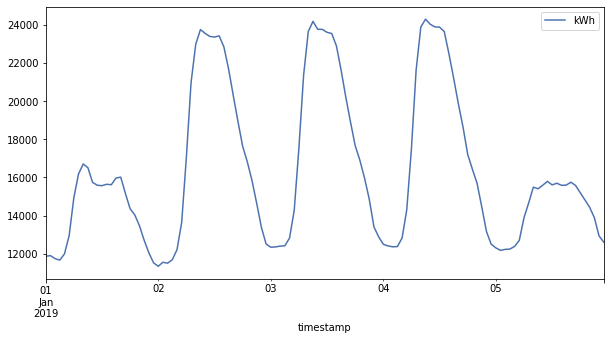

In [4]:
ts.head(120).plot(figsize=(10,5))

<AxesSubplot:xlabel='timestamp'>

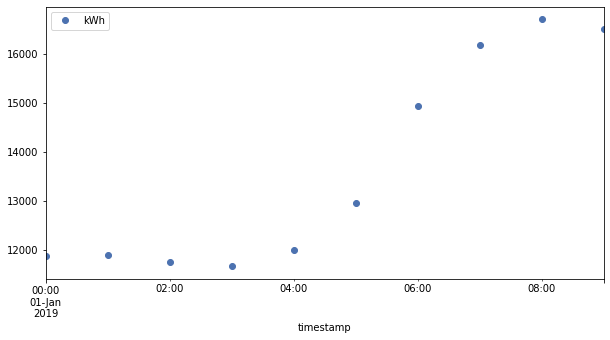

In [7]:
ts.head(10).plot(figsize=(10,5),style="o")

## Feature Engineering <a class="anchor" id="1.1."></a>

By preparing the data well in advance, we can help simplify models and improve their performance by a great extent with comparatively little effort. This means to come up with better representations of data or adding more useful information, i.e. to engineer features.

### Holidays Data Generation <a class="anchor" id="1.1.1."></a>

To get started, the exogenous 'holiday' variable can be reused entirely from the SARIMAX model.

In [4]:
import holidays

# begin = '2017-01-01'
# end = '2019-12-31'
begin = '2019-01-01'
end = '2019-04-01'
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:end])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.loc["2020-01-01","holidays"] = 1

ts["holidays"] = exo["holidays"]
ts

,kWh,holidays
timestamp,,
2019-01-01 00:00:00,11865.25,1.0
2019-01-01 01:00:00,11898.05,0.0
2019-01-01 02:00:00,11741.78,0.0
2019-01-01 03:00:00,11662.78,0.0
2019-01-01 04:00:00,11986.15,0.0
...,...,...
2019-03-31 20:00:00,13619.95,0.0
2019-03-31 21:00:00,13476.02,0.0
2019-03-31 22:00:00,12665.50,0.0


### Cyclical feature encoding <a class="anchor" id="1.1.2."></a>

The separate datetime data on its own is not very useful to the learning task. Therefore, we need a way to encode the periodicity of the time series from our knowledge into the data. This can be achieved by modelling time as a circular scale, which is simply mapping the date time values using trigonometric functions.

In [5]:
date = ts.index
timestamp_s = date.map(datetime.datetime.timestamp)

In [6]:
week = 7*24*60*60
ts['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
ts['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

Text(0.5, 1.0, 'Time of week signal')

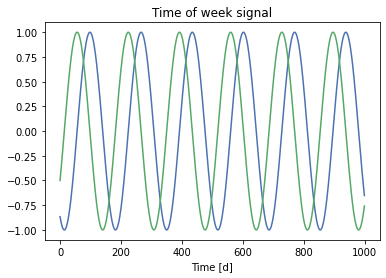

In [7]:
# plt.plot(np.array(ts['Week sin'])[:22])
# plt.plot(np.array(ts['Week cos'])[:22])
plt.plot(np.array(ts['Week sin'])[:1000])
plt.plot(np.array(ts['Week cos'])[:1000])

plt.xlabel('Time [d]')
plt.title('Time of week signal')

In [12]:
ts.head(10)

,kWh,holidays,Week sin,Week cos
timestamp,,,,
2019-01-01 00:00:00,11865.25,1.0,-0.866025,-0.500000
2019-01-01 01:00:00,11898.05,0.0,-0.884115,-0.467269
2019-01-01 02:00:00,11741.78,0.0,-0.900969,-0.433884
2019-01-01 03:00:00,11662.78,0.0,-0.916562,-0.399892
2019-01-01 04:00:00,11986.15,0.0,-0.930874,-0.365341
2019-01-01 05:00:00,12943.41,0.0,-0.943883,-0.330279
2019-01-01 06:00:00,14931.95,0.0,-0.955573,-0.294755
2019-01-01 07:00:00,16181.15,0.0,-0.965926,-0.258819
2019-01-01 08:00:00,16702.43,0.0,-0.974928,-0.222521


In [13]:
ts.describe()

,kWh,holidays,Week sin,Week cos
count,2161.000000,2161.000000,2.161000e+03,2.161000e+03
mean,18607.833350,0.000925,5.812733e-03,8.525714e-03
std,6777.247541,0.030415,7.084575e-01,7.060060e-01
min,11341.540000,0.000000,-1.000000e+00,-1.000000e+00
25%,13263.920000,0.000000,-7.071068e-01,-7.071068e-01
50%,15343.340000,0.000000,7.946090e-13,8.735041e-13
75%,23117.960000,0.000000,7.071068e-01,7.071068e-01
max,34619.010000,1.000000,1.000000e+00,1.000000e+00


### Feature Vector Normalization <a class="anchor" id="1.1.3."></a>

Since there are big discrepancies between the scales of the different features, we need to normalize them into a common scale, without distorting the differences in the ranges of values or losing information.

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts[["kWh"]])
ts_normalized = pd.DataFrame(scaler.fit_transform(ts),
                             columns = ts.columns.values,
                            index = ts.index)

In [15]:
ts_normalized

,kWh,holidays,Week sin,Week cos
timestamp,,,,
2019-01-01 00:00:00,0.022499,1.0,0.066987,0.250000
2019-01-01 01:00:00,0.023908,0.0,0.057942,0.266366
2019-01-01 02:00:00,0.017194,0.0,0.049516,0.283058
2019-01-01 03:00:00,0.013800,0.0,0.041719,0.300054
2019-01-01 04:00:00,0.027692,0.0,0.034563,0.317329
...,...,...,...,...
2019-03-31 20:00:00,0.097880,0.0,0.500000,0.000000
2019-03-31 21:00:00,0.091697,0.0,0.481304,0.000350
2019-03-31 22:00:00,0.056877,0.0,0.462635,0.001398


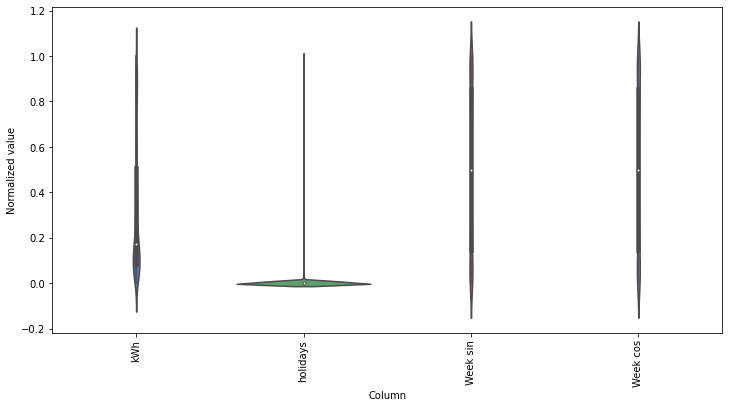

In [16]:
melt_plot = ts_normalized.melt(var_name='Column', value_name='Normalized value')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized value', data=melt_plot)
_ = ax.set_xticklabels(ts_normalized.keys(), rotation=90)

## Modeling <a class="anchor" id="1.2."></a>

Certainly, we need to split the dataset into train, validation, and test sets first. The test set here will be of the same time period as the one in the SARIMAX model, so we can compare the performance more easily.

In [9]:
# train_end = '2019-12-01'
# test_end = '2020-01-01'
# demo_start = '2019-11-25'
train_end = '2019-03-24'
test_end = '2019-04-01'
demo_start = '2019-03-25'

test_df = ts_normalized[train_end:]
train_val = ts_normalized[:train_end]

n = len(train_val)

train_df = train_val[:int(n*0.8)]
val_df = train_val[int(n*0.8):]

column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]
train_df

,kWh,holidays,Week sin,Week cos
timestamp,,,,
2019-01-01 00:00:00,0.022499,1.0,0.066987,0.250000
2019-01-01 01:00:00,0.023908,0.0,0.057942,0.266366
2019-01-01 02:00:00,0.017194,0.0,0.049516,0.283058
2019-01-01 03:00:00,0.013800,0.0,0.041719,0.300054
2019-01-01 04:00:00,0.027692,0.0,0.034563,0.317329
...,...,...,...,...
2019-03-08 04:00:00,0.070815,0.0,0.840086,0.866526
2019-03-08 05:00:00,0.138671,0.0,0.853553,0.853553
2019-03-08 06:00:00,0.322976,0.0,0.866526,0.840086


In [10]:
# data loading

nusers=50

user_tr_data_tensors=[]
user_tr_label_tensors=[]

for i in range(nusers):
    
    user_tr_data_tensor=torch.from_numpy(total_tr_data[user_tr_len*i:user_tr_len*(i+1)]).type(torch.FloatTensor)
    user_tr_label_tensor=torch.from_numpy(total_tr_label[user_tr_len*i:user_tr_len*(i+1)]).type(torch.LongTensor)

    user_tr_data_tensors.append(user_tr_data_tensor)
    user_tr_label_tensors.append(user_tr_label_tensor)
    print('user %d tr len %d'%(i,len(user_tr_data_tensor)))

NameError: name 'total_tr_data' is not defined

In order for the LSTM to work, we need to create sliding windows from the data so that for each datapoint, its features is the window of a determined size of the past values . In this project, the width of the features vector is 28 days, or 4 weeks, while there is only one label for each window. 

![A window of data](data_window.png "A window of data")

In [11]:
import random

def split_sequence(df, fea_width=28, label_width=1, shift=1, label_col_indices=[0], randomize = True):
    
    """ Split sequence with sliding window into
        sequences of context features and label.
        Args:
            df (DataFrame): the target time series
            fea_width (int): Length of features vector.
            label_width (int): Length of labels vector.
            shift (int): Distance between the features vector and the labels one. 
            label_col_indices (list): list of the columns for the labels.
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of targets
    """
    arr = df.to_numpy()

    # Work out the label column indices.

    window_size = fea_width + shift + label_width - 1
    fea_slice = slice(0, fea_width)
    fea_indices = np.arange(window_size)[fea_slice]

    label_slice = slice(window_size - label_width, None)
    label_indices = np.arange(window_size)[label_slice]
    
    
    print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
          .format(window_size,fea_indices,label_indices))
    
    
    def split_window(window):
        features = window[fea_slice]
        labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
        if label_col_indices is not None:
            labels = np.stack(
                [labels[:, label_col_indices[idx]] 
                 for idx in label_col_indices],
                axis=-1)
        
        labels = labels.flatten()
        
        return features, labels
            
    n = len(arr)
    X,y = list(),list()
    for i in range(0, n, shift):
        
        window = arr[i:i+window_size]
        if (len(window) != window_size): break
        
        # Find the end of this pattern:
        features,labels = split_window(window)
        X.append(features)
        y.append(labels)
        
#     print(label_col_indices)
#     if randomize == True:
#         random.shuffle(X)
#         random.shuffle(y)
    
    return X,y

In [12]:
fea_width, label_width, shift, label_col_indices = 28, 1, 1, [0]

X_ts,y_ts = split_sequence(ts_normalized,randomize=False)

X_train,y_train = split_sequence(train_df)
X_val,y_val = split_sequence(val_df)
X_test,y_test = split_sequence(test_df)

X_train[0].shape,y_train[0].shape


 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]


((28, 4), (1,))

The only secondary step left is to convert the data into Pytorch Tensors.

In [13]:
def to_tensor(ls):
    return Variable(torch.cuda.FloatTensor(np.array(ls)))

X_ts,y_ts = to_tensor(X_ts),to_tensor(y_ts)

X_train,y_train = to_tensor(X_train),to_tensor(y_train)
X_val,y_val = to_tensor(X_val),to_tensor(y_val)
X_test = to_tensor(X_test)

X_train

tensor([[[0.0225, 1.0000, 0.0670, 0.2500],
         [0.0239, 0.0000, 0.0579, 0.2664],
         [0.0172, 0.0000, 0.0495, 0.2831],
         ...,
         [0.0090, 0.0000, 0.0417, 0.6999],
         [0.0069, 0.0000, 0.0495, 0.7169],
         [0.0147, 0.0000, 0.0579, 0.7336]],

        [[0.0239, 0.0000, 0.0579, 0.2664],
         [0.0172, 0.0000, 0.0495, 0.2831],
         [0.0138, 0.0000, 0.0417, 0.3001],
         ...,
         [0.0069, 0.0000, 0.0495, 0.7169],
         [0.0147, 0.0000, 0.0579, 0.7336],
         [0.0373, 0.0000, 0.0670, 0.7500]],

        [[0.0172, 0.0000, 0.0495, 0.2831],
         [0.0138, 0.0000, 0.0417, 0.3001],
         [0.0277, 0.0000, 0.0346, 0.3173],
         ...,
         [0.0147, 0.0000, 0.0579, 0.7336],
         [0.0373, 0.0000, 0.0670, 0.7500],
         [0.0987, 0.0000, 0.0766, 0.7660]],

        ...,

        [[0.0638, 0.0000, 0.3887, 0.9875],
         [0.0706, 0.0000, 0.4070, 0.9913],
         [0.0806, 0.0000, 0.4255, 0.9944],
         ...,
         [0.0524, 0.0

We now can finally get to building the neural network! Our model has 2 hidden LSTM layers with 512 neurons each. The input and output layers has 4 and 1 nodes, respectively, which corresponds to the shape of the features and labels vector. The Adam optimizer is used, and the learning rate is dynamically modified using a scheduler.

In [17]:
from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from torch.autograd import Variable

import torch
import torch
import torch.nn as nn

In [15]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
num_epochs = 300
learning_rate = 1e-3
input_size = 4
hidden_size = 512
num_layers = 2

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.cuda()


model.apply(init_weights)

criterion = torch.nn.MSELoss().cuda()    # Will be transformed to root mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [61]:
LSTM_fc = model.state_dict()['fc.weight']
print(len(LSTM_fc[0]))
print(LSTM_fc[0][:10])

tensor([ 1.7942,  0.1641, -0.0381,  0.2231,  0.3100, -0.4622,  0.1295, -0.6210,
         1.7556, -1.3014], device='cuda:0')


In [18]:
for epoch in progress_bar(range(1,num_epochs+1)):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    
    loss = torch.sqrt(criterion(y_pred, y_train))
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    valid = model(X_val)
    val_loss = torch.sqrt(criterion(valid, y_val))
    scheduler.step(val_loss)
    
    
    if epoch <=40:
        y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
        y_test_obs = scaler_kwh.inverse_transform(y_test)
        print('RMSE ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)) +
      '\nMAPE ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)))
    elif epoch > 40 and epoch % 10==0:
        y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
        y_test_obs = scaler_kwh.inverse_transform(y_test)
        print('RMSE ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)) +
      '\nMAPE ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)))
    if epoch%20 == 1:
        print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

RMSE 6673.68
MAPE 0.38
Epoch: 1, loss: 0.40918 validation loss:  0.28624 
RMSE 6242.61
MAPE 0.24
RMSE 6307.74
MAPE 0.21
RMSE 5863.15
MAPE 0.21
RMSE 5447.49
MAPE 0.25
RMSE 5583.9
MAPE 0.32
RMSE 5699.46
MAPE 0.34
RMSE 5163.54
MAPE 0.29
RMSE 4539.58
MAPE 0.22
RMSE 4234.46
MAPE 0.16
RMSE 3935.25
MAPE 0.13
RMSE 3376.15
MAPE 0.13
RMSE 3018.57
MAPE 0.15
RMSE 3707.25
MAPE 0.19
RMSE 3715.89
MAPE 0.2
RMSE 3010.29
MAPE 0.16
RMSE 2675.82
MAPE 0.13
RMSE 2697.19
MAPE 0.11
RMSE 2803.3
MAPE 0.12
RMSE 2869.4
MAPE 0.13
RMSE 2756.56
MAPE 0.13
Epoch: 21, loss: 0.12593 validation loss:  0.11667 
RMSE 2534.47
MAPE 0.12
RMSE 2350.36
MAPE 0.11
RMSE 2232.97
MAPE 0.11
RMSE 2260.36
MAPE 0.11
RMSE 2405.09
MAPE 0.12
RMSE 2294.96
MAPE 0.11
RMSE 2027.83
MAPE 0.1
RMSE 1822.37
MAPE 0.08
RMSE 1802.7
MAPE 0.08
RMSE 1832.79
MAPE 0.09
RMSE 1682.66
MAPE 0.08
RMSE 1554.34
MAPE 0.07
RMSE 1497.21
MAPE 0.07
RMSE 1683.71
MAPE 0.08
RMSE 1702.62
MAPE 0.08
RMSE 1542.84
MAPE 0.07
RMSE 1469.68
MAPE 0.06
RMSE 1449.73
MAPE 0.06
RMSE 1

In [146]:
w = model.state_dict()
model_defect = LSTM(num_classes, input_size, hidden_size, num_layers)
model_defect.cuda()
model_defect.load_state_dict(w)
w_defect = model_defect.state_dict()
w_defect['fc.weight'] += 0.1*torch.randn(1,512).to('cuda:0')
model_defect.load_state_dict(w_defect)
print(model_defect.state_dict()['fc.weight'][0][:10])

tensor([-0.1074, -0.0699, -0.0748,  0.1392, -0.0849, -0.1291,  0.0390, -0.0488,
        -0.1023,  0.1036], device='cuda:0')


So far, so good. Now we need to check the error of the model on the test set without normalization. 

In [147]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

model.eval()
model_defect.eval()
## Inverse Normalize 
y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
y_test_pred_defect = scaler_kwh.inverse_transform(model_defect(X_test).cpu().detach().numpy())
y_test_obs = scaler_kwh.inverse_transform(y_test)

print('The root mean squared error of the model is ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)) +
      '\nThe MAPE of the model is ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)))

print('The defect root mean squared error of the model is ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred_defect)),2)) +
      '\nThe defect MAPE of the model is ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred_defect),2)))

The root mean squared error of the model is 770.79
The MAPE of the model is 0.03
The defect root mean squared error of the model is 4652.37
The defect MAPE of the model is 0.23


This is only a marginal improvement over the SARIMAX model. In fact, we can see that the LSTM model performs worse than the classical method after accounting for the far greater level of complexity of the Deep Neural Networks. This is in agreement with the literature on time series forecasting, with deep learning methods having not delivered on their promises.

Nevertheless, we can further examine the fitness of the model on the data by visualizing the results, starting with the all the data available.

Text(0, 0.5, 'kWh')

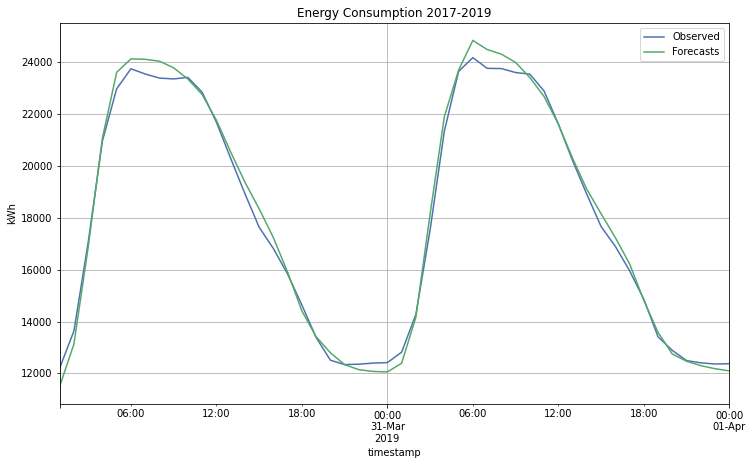

In [20]:
y_pred = scaler_kwh.inverse_transform(model(X_ts[:48]).cpu().detach().numpy())
# y_pred_defect = scaler_kwh.inverse_transform(model_defect(X_ts).cpu().detach().numpy())
y_obs = scaler_kwh.inverse_transform(y_ts[:48].cpu().numpy())

pred_df = pd.DataFrame(y_pred,index = ts.index[-len(y_pred):],columns = ["kWh"])
# pred_df_defect = pd.DataFrame(y_pred_defect, index = ts.index[-len(y_pred_defect):],columns = ["kWh"])
obs_df = pd.DataFrame(y_obs,index = ts.index[-len(y_pred):],columns = ["kWh"])

fig, ax = plt.subplots()
plot_df = pd.concat([obs_df,pred_df],axis=1)
# plot_df_defect = pd.concat([pred_df_defect],axis=1)
plot_df.plot(ax=ax,figsize=(12,7),style = '-', grid=True)
# plot_df_defect.plot(ax=ax,figsize=(12,7),style = '-', grid=True)
ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption 2017-2019")
ax.set_ylabel("kWh")

The forecasts appear to fit the observed values well, but is worse than that of the SARIMA with consistent under-prediction of the max values. Let us look at the prediction on the test set compare it with that of the SARIMAX.

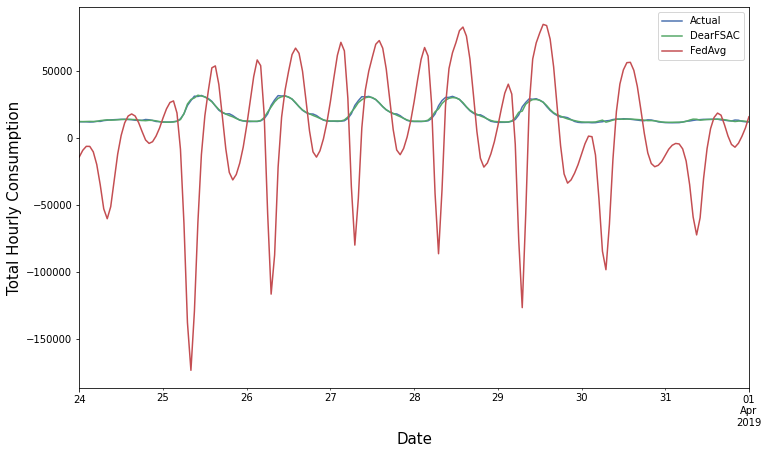

In [143]:
fig, ax = plt.subplots()
plot_df.loc[train_end:].plot(ax = ax, figsize=(12,7), grid=True)
plot_df_defect.loc[train_end:].plot(ax = ax, figsize=(12,7), grid=True)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Total Hourly Consumption',fontsize=15)
plt.grid()
ax.legend(["Actual", "DearFSAC","FedAvg"])
plt.savefig('Result.pdf',bbox_inches = 'tight')
plt.show()  

# ax.set_title("Energy Consumption 2019")
# ax.set_ylabel("kWh")

Despite better fitness during some time points, the model consistently under-predict the values by a wide margin. Concerning the holiday period, the forecasts still have the same defects as that of the SARIMAX model.

In conclusion, even though the presented models have presented reasonable accuracy, time series forecasting still presents many challenges. That said, this is still a very active research area, offering much improvement in the future.

# Further Readings <a class="anchor" id="2."></a>

* [Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition. *OTexts: Melbourne, Australia*](https://otexts.com/fpp2/)
* [Shumway, R., & Stoffer, D. (2017). Time Series Analysis and Its Applications. *Springer Texts In Statistics*. https://doi.org/10.1007/978-3-319-52452-8](https://www.springer.com/gp/book/9783319524511)
*[SARIMAX: Introduction. *Statsmodels.org. (2021)*. Retrieved 17 January 2021.](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html.)
* [NIST/SEMATECH e-Handbook of Statistical Methods. Retrieved 17 January 2021.](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc445.htm)
* [Time series forecasting: TensorFlow Core.](https://www.tensorflow.org/tutorials/structured_data/time_series#feature_engineering)
* [Zhang, G. (2012). Neural Networks for Time-Series Forecasting. *Handbook of Natural Computing*, 461–477.](https://link.springer.com/referenceworkentry/10.1007%2F978-3-540-92910-9_14#citeas)